 # Easy 21 Control Assignment
 ### Exercise instructions:
 In this assignment, we want to learn the state-value function for a given policy \pi
 Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits,
 plus other player’s policies of your choice.  For each of the 2 policies, and for each
 algorithm, plot the optimal value function v_\pi using similar axes to the Figure 5.2 (right)
 from Sutton and Barto’s book. Note that now the dealer can show either a black or a red card.

 ### Possible actions:
 - stick - Don't draw any new cards
 - hit - draw new card

 ### State definition:
 - Values of the player’s cards (added (black cards) or subtracted (red cards))
 - Value of dealer's cards

 ### State-Action transitions:
 - stick -> draw new card
 - hit -> The dealer always sticks on any sum of 17 or greater, and hits otherwise.

 ### Draw card:
 - number 1-10 uniform distribution
 - Color: 1/3 red 2/3 black

ATENTION: This Notebook original code can be found in my [github account](https://github.com/renato-scaroni/ReinforcementLearning-knowledgeBase/blob/master/Implementations/easy21/Easy21-control-scaroni.ipynb)

 # Part 1 - Implementation of Easy21 simulator

In [2]:
# %load easy21-environment.py

##################################################################################################
#                                  Environment implementation                                    #
##################################################################################################


import random

# defining constants
CARD_MAX_ABS_VALUE = 10
CARD_MIN_ABS_VALUE = 1
RED = "red"
BLACK = "black"
HIT = 0
STICK = 1
PLAYER = 0
DEALER = 1

class State:
    def __init__(self):
        self.random = random.Random()
        self.playerPoints = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)
        self.dealerPoints = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)
        self.isTerminal = False

    def toStateTuple(self):
        return (self.playerPoints, self.dealerPoints)

    def updateState(self, card, agent):
        if agent == PLAYER:
            self.playerPoints += card.value
        else:
            self.dealerPoints += card.value

    def __str__(self):
        return "(Pl, De) = ({0}, {1})".format(self.playerPoints, self.dealerPoints)

class Card(object):
    def __init__ (self):
        self.color = Card.getColor()
        self.absValue = random.randint(CARD_MIN_ABS_VALUE, CARD_MAX_ABS_VALUE)
        self.value = self.absValue if self.color == BLACK else -self.absValue

    @staticmethod
    def getColor():
        colorVariable = random.randint(1,3)
        return RED if colorVariable == 1 else BLACK

class Policy:
    def act(self, state):
        pass

class DefaultDealerPolicy(Policy):
    def act(self, state):
        if state.dealerPoints >= 17:
            return STICK

        return HIT

class DefaultPlayerPolicy(Policy):
    def act(self, state):
        if state.playerPoints >= 20:
            return STICK

        return HIT

class EpisodeStep:
    def __init__(self, state, action, reward, timeStep):
        self.state = state
        self.action = action
        self.reward = reward
        self.timeStep = timeStep
    def __str__(self):
        return "(S, A, R, t) = ({0}, {1}, {2}, {3})".format(str(self.state), "hit" if self.action == 0 else "stick", str(self.reward), self.timeStep)


class Game:
    def __init__(self, playerPolicy=None, debug=False):
        self.currentState = State()
        self.playerPolicy = playerPolicy
        self.dealerPolicy = DefaultDealerPolicy()
        self.debug = debug
        self.RandomReset()


    def rewardFunction(self, state):
        if state.playerPoints > 21 or state.playerPoints < 1:
            return -1
        if state.dealerPoints > 21 or state.dealerPoints < 1:
            return 1
        if not state.isTerminal:
            return 0
        if state.dealerPoints == state.playerPoints:
            return 0
        if state.playerPoints - state.dealerPoints > 0:
            return 1
        else:
            return -1

    def step (self, state, playerAction):
        if playerAction == HIT and (state.playerPoints <= 21 or state.playerPoints > 0):
            card = Card()
            if self.debug: print ("Player Hit:", card.value, card.color)
            state.updateState(card, PLAYER)
            if self.debug: print("Current state:", state.playerPoints, state.dealerPoints)
            if state.playerPoints > 21 or state.playerPoints < 1:
                state.isTerminal = True
        elif state.dealerPoints <= 21 or state.dealerPoints > 0:
            if self.debug: print ("Player stick", str(state))
            dealerAction = self.dealerPolicy.act(state)
            while dealerAction == HIT:
                card = Card()
                if self.debug: print ("Dealer Hit:", card.value, card.color)
                state.updateState(card, DEALER)
                if self.debug: print("Current state:", state.playerPoints, state.dealerPoints)
                dealerAction = self.dealerPolicy.act(state)
            state.isTerminal = True

        return self.rewardFunction(state), state

    def SimulateEpisode(self):
        episodes = []
        t = 0
        self.currentState = State()
        if self.debug: print("Initial state:", self.currentState.playerPoints, self.currentState.dealerPoints)
        while not self.currentState.isTerminal:
            stateTuple = (self.currentState.playerPoints, self.currentState.dealerPoints)
            playerAction = self.playerPolicy.act(self.currentState)
            reward, _ = self.step(self.currentState, playerAction)
            t += 1
            episodes.append(EpisodeStep(stateTuple, playerAction, reward, t))

        if self.debug: print("End state:", self.currentState.playerPoints, self.currentState.dealerPoints)

        return episodes

    def SimulateMultipleEpisodes(self, n):
        sample = []
        self.RandomReset()
        for i in range(n):
            sample.append(self.SimulateEpisode())

        return sample

    def RandomReset(self):
        random.seed(10)


 # Auxiliary functions and imports for the tests

In [3]:
##################################################################################################
#                                             Imports                                            #
##################################################################################################

get_ipython().run_line_magic('matplotlib', 'inline')
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd
from sys import argv
from itertools import product
import sys
from time import time



In [4]:
##################################################################################################
#                                         Auxiliary methods                                      #
##################################################################################################

# extract state-value function to be plotted from a optimal action-value function
def extractValueFunction(q):
    v = []
    for k in q:
        v.append(((k[0], k[1]), q[k]))
    return v

def argmaxA(q, s):
    if (s[0], s[1], HIT) in q:
        return HIT if q[(s[0], s[1], HIT)] > q[(s[0], s[1], STICK)] else STICK
    return 0

def getStateActionVisits(episode):
    firstStateActionVisits = {}
    everyStateVisitsCount = dict.fromkeys(product(range(1, 22), range(1, 11)), 0)
    for t in range(len(episode)):
        step = episode[t]
        everyStateVisitsCount[step.state] += 1
        if not step.state in firstStateActionVisits:
            firstStateActionVisits[(step.state[0], step.state[1], step.action)] = t+1

    return firstStateActionVisits, everyStateVisitsCount

def getPolicy(q):
    plotablePi = []
    for i in range(1, 11):
        plotablePi.append([])
        for j in range(1, 22):
            plotablePi[i-1].append(argmaxA(q, (j,i)))

    return plotablePi

In [10]:
##################################################################################################
#                                          Plotting methods                                      #
##################################################################################################

def plotMutipleValueFunction(vPis, sizes, rows=2, cols=3, message='episode', width=19, height=9.5):
    fig = plt.figure(figsize=(width, height))
    for i in range(len(vPis)):
        ax = fig.add_subplot(rows, cols, i+1, projection='3d')
        ax.set_title("{} {}{}".format(sizes[i], message,'s' if i > 0 else ''),
                     fontsize=12)
        plotSurface(vPis[i], ax)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

def plotSurface(vPi, ax):
    x = list(map(lambda x: x[0][1], vPi))
    y = list(map(lambda y: y[0][0], vPi))
    z = list(map(lambda x: x[1], vPi))
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})


    ax.set_xlabel('Dealer initial card')
    ax.set_ylabel('Player card sum')
    ax.set_zlabel('State value')

    ax.set_xticks(range(1,11))
    ax.set_yticks(range(1,22,2))
    ax.set_zlim([-1, 1])

    ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.coolwarm, linewidth=0.1)

def plotValueFunction(vPi):
    x = list(map(lambda x: x[0][1], vPi))
    y = list(map(lambda y: y[0][0], vPi))
    z = list(map(lambda x: x[1], vPi))
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel('Dealer initial card')
    ax.set_ylabel('Player card sum')
    ax.set_zlabel('State value')

    ax.set_xticks(range(1,11))
    ax.set_yticks(range(1,22,2))
    ax.set_zlim([-1, 1])

    surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.coolwarm, linewidth=0.1)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

def plotMutiplePolicies(qs, sizes, rows=2, cols=3, message='', width=25, height=12):
    fig = plt.figure(figsize=(width, height))
    for i in range(len(qs)):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title("{} {}".format(sizes[i], message if i > 0 else ''),
                     fontsize=12)
        plotPolicy(getPolicy(qs[i]), ax)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

def plotPolicy(plotablePi, ax):
    im = ax.imshow(np.array(plotablePi), cmap=cm.Pastel1)

    # We want to show all ticks...
    ax.set_xticks(range(21))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(1, 22))
    ax.set_yticklabels(range(1, 11))

    for i in range(10):
        for j in range(21):
            text = ax.text(j,i, "hit" if plotablePi[i][j] == 0 else "stick",
                           ha="center", va="center", color="w")


In [19]:
##################################################################################################
#                          TD on-policy Q-learning algorithm for control                         #
##################################################################################################

def getNextAction(stateTuple, q, epsilon):
    if random.random() < epsilon:
        playerAction = random.randint(0, 1)
    else:
        playerAction = argmaxA(q, stateTuple)

    return playerAction


def DynaQLearning(episodes, n, gamma=1, n0 = 100, everyVisit=True):
    # Generic Monte Carlo initialization
    q = dict.fromkeys(product(range(1, 22), range(1, 11), range(0,2)), 0)
    model = {}
    nStateAction = dict.fromkeys(product(range(1, 22), range(1, 11), range(0,2)), 0)
    nState = dict.fromkeys(product(range(1, 22), range(1, 11)), 0)
    game = Game()
    game.RandomReset()
    epsilon = 1
    for _ in range(episodes):
        S = State()
        while not S.isTerminal:
            A = getNextAction(S.toStateTuple(), q, epsilon)
            SA = (S.playerPoints, S.dealerPoints, A)
            
            R, SPrime = game.step(S, A)
            APrime = getNextAction(SPrime.toStateTuple(), q, 0)
            SAPrime = (SPrime.playerPoints, SPrime.dealerPoints, APrime)
            
            # In case the current state is terminal, there is no action for 
            # it to be taken so we set q(S, A) = 0
            QSAPrime = 0 if SPrime.isTerminal else q[SAPrime]
            nStateAction[SA] += 1
            q[SA] += 1/nStateAction[SA] * (R + gamma*QSAPrime - q[SA])

            nState[SA[:2]] += 1
            epsilon = n0/(n0+nState[SA[:2]])

            S = SPrime
            
            model[SA] = (R, SPrime)
            
            for _ in range(n):
                key = random.choice(list(model.keys()))
                Smodel = key[:2]
                Amodel = key[2]
                R, SmodelPrime = model[SA]
                AmodelPrime = getNextAction(SmodelPrime.toStateTuple(), q, 0)
                SAmodelPrime = (SmodelPrime.playerPoints, SmodelPrime.dealerPoints, AmodelPrime)
        
    return q

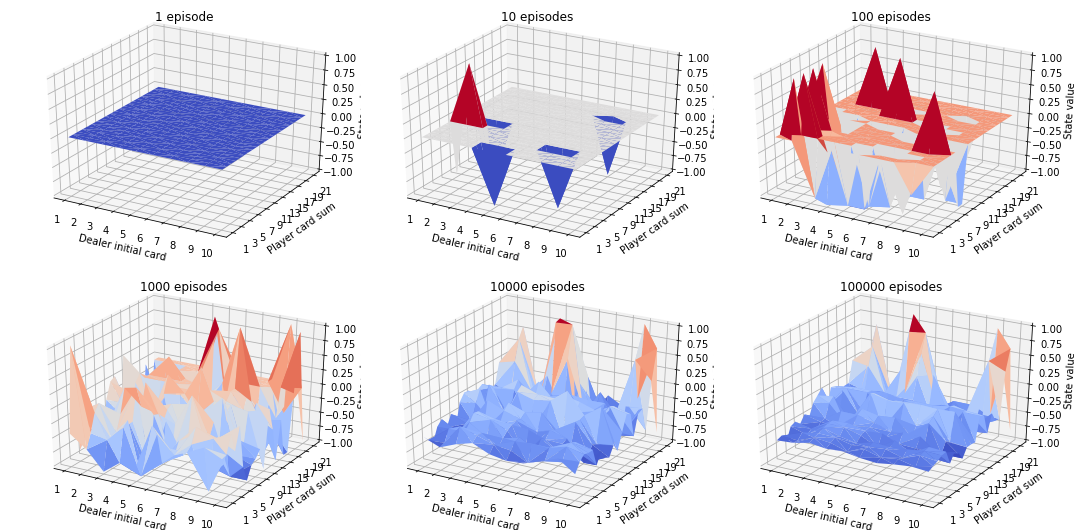

In [22]:
##################################################################################################
#              Q-learning execution for 1, 10, 100, 1000, 10000 and 100000 episodes              #
##################################################################################################

sizes = [1, 10, 100, 1000, 10000, 100000]
vStarsQLearning = []
qQLearning = []
for numberOfEpisodes in sizes:
    q = DynaQLearning(numberOfEpisodes,0)
    qQLearning.append(q)
    vStarsQLearning.append(extractValueFunction(q))

plotMutipleValueFunction(vStarsQLearning, sizes)


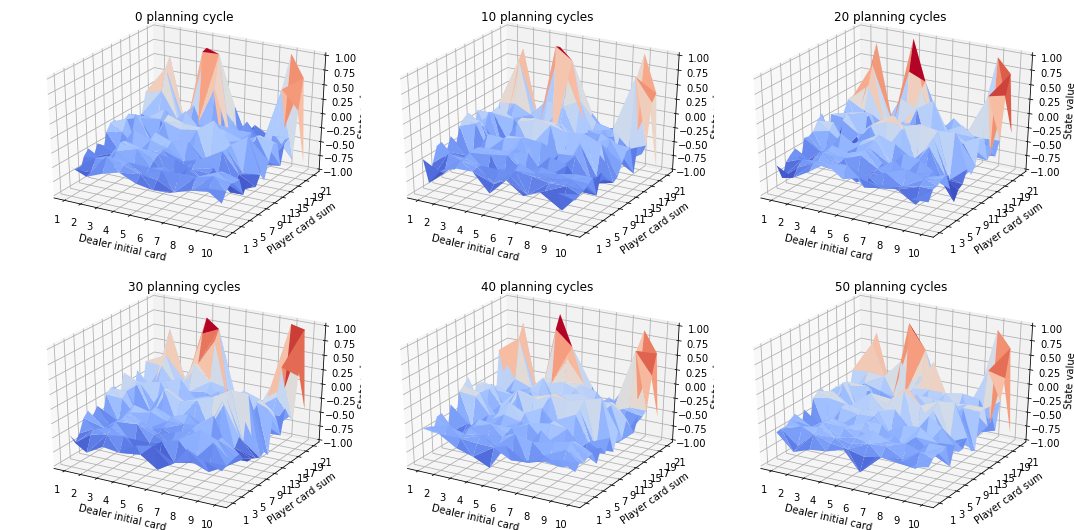

In [23]:
##################################################################################################
#              Q-learning execution for 1, 10, 100, 1000, 10000 and 100000 episodes              #
##################################################################################################

sizes = [0, 10, 20,30,40,50]
vStarsQLearning = []
qQLearning = []
for numberOfEpisodes in sizes:
    q = DynaQLearning(10000,numberOfEpisodes)
    qQLearning.append(q)
    vStarsQLearning.append(extractValueFunction(q))

plotMutipleValueFunction(vStarsQLearning, sizes, message="planning cycle")


In [13]:
##################################################################################################
#                          TD on-policy SARSA(lambda) algorithm for control                      #
##################################################################################################

def getNextAction(stateTuple, q, epsilon):
    if random.random() < epsilon:
        playerAction = random.randint(0, 1)
    else:
        playerAction = argmaxA(q, stateTuple)

    return playerAction

possibleStateAction = list(product(range(1, 22), range(1, 11), range(0,2)))
def SARSALambda(episodes, lam, gamma=1, n0 = 100, everyVisit=True):
    stateActionDict = dict.fromkeys(product(range(1, 22), range(1, 11), range(0,2)), 0)
    q = stateActionDict.copy()
    nStateAction = stateActionDict.copy()
    e = stateActionDict.copy()
    nState = dict.fromkeys(product(range(1, 22), range(1, 11)), 0)
    game = Game()
    game.RandomReset()
    epsilon = 1
    count = 0
    for _ in range(episodes):
        S = State()
        A = getNextAction(S.toStateTuple(), q, epsilon)
        e = stateActionDict.copy()
        while not S.isTerminal:
            SA = (S.playerPoints, S.dealerPoints, A)
            R, SPrime = game.step(S, A)
            APrime = getNextAction(SPrime.toStateTuple(), q, epsilon)
            SAPrime = (SPrime.playerPoints, SPrime.dealerPoints, APrime)
            
            # In case the current state is terminal, there is no action for 
            # it to be taken so we set q(S, A) = 0 in this case
            QSAPrime = 0 if SPrime.isTerminal else q[SAPrime]
            delta = R + gamma*QSAPrime - q[SA]
                        
            nStateAction[SA] += 1
            e[SA] += 1
            
            count += 1
            for stateAction in possibleStateAction:
                alpha = 1/nStateAction[stateAction] if not nStateAction[stateAction] == 0 else 0
                q[stateAction] += alpha * delta * e[stateAction]
                e[stateAction] = gamma*lam*e[stateAction]
            nState[SA[:2]] += 1
            epsilon = n0/(n0+nState[SA[:2]])
            
            A = APrime
            S = SPrime
    return q

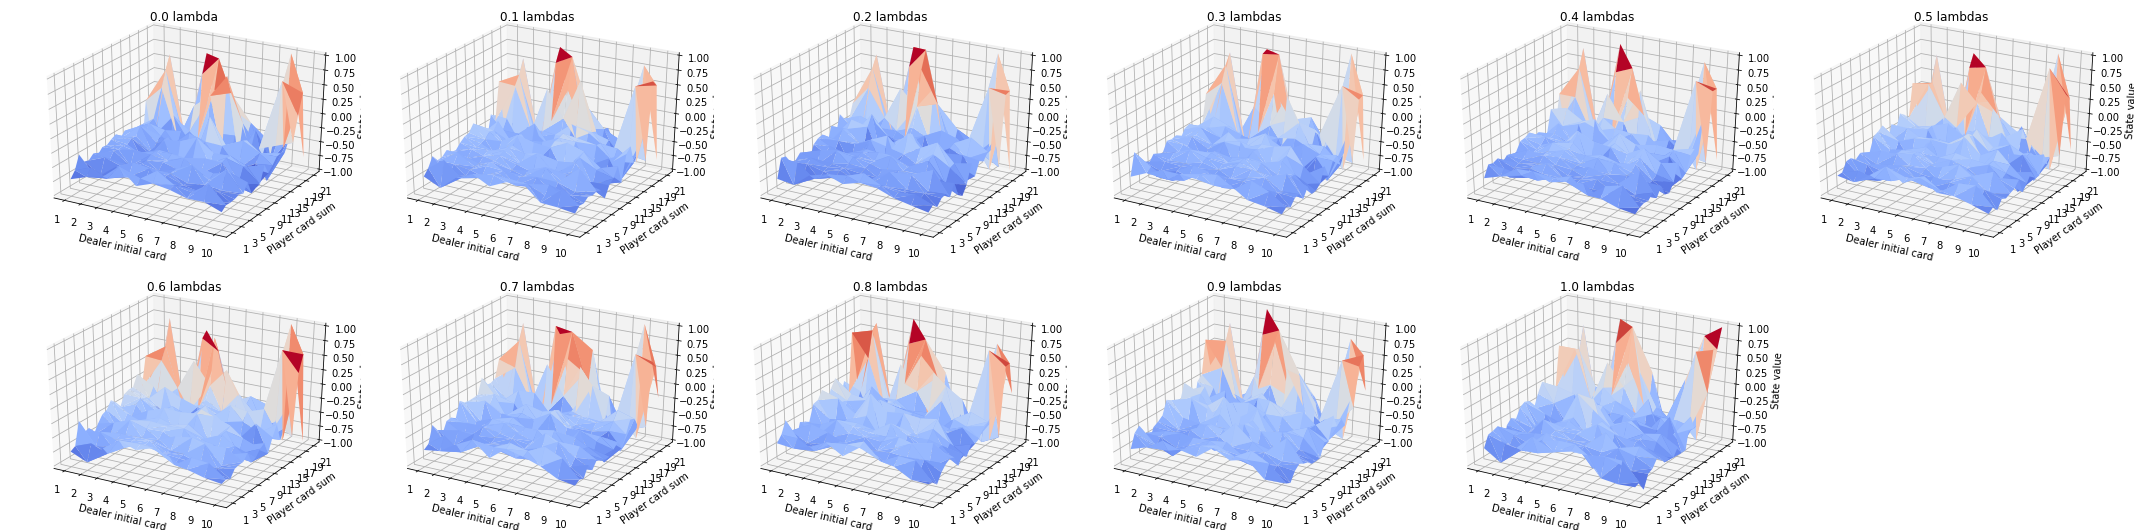

In [14]:
##################################################################################################
#             SARSA (lambda) execution for 1, 10, 100, 1000, 10000 and 100000 episodes           #
##################################################################################################

lambdas = [round(i, 1) for i in np.arange(0, 1.1, 0.1)]
# sizes = [1000]
vStarsSARSALambda = []
qSARSALambda = []
for lam in lambdas:
    q = SARSALambda(10000, lam)
    qSARSALambda.append(q)
    vStarsSARSALambda.append(extractValueFunction(q))

plotMutipleValueFunction(vStarsSARSALambda, lambdas, rows=2, cols=6, message='lambda', width=38, height=9.5)

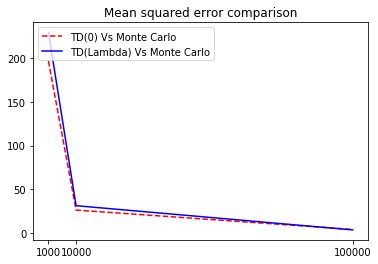

In [25]:
##########################################################################################################
# The graphs bellow ilustrate the convergence of SARSALambda methods to Monte Carlo as lambda tends to 1
# and to SARSAZero as lambda tends to zero
##########################################################################################################

def mse(q1, q2):
    stateActions = list(product(range(1, 22), range(1, 11), range(2)))
    e = 0
    for sa in stateActions:
        e += (q1[sa] - q2[sa])**2
    return e

episodes = [10**i for i in range(3, 6)]

err = []
err2 = []
for numberOfEpisodes in episodes:
    q1 = MonteCarloControl(numberOfEpisodes, everyVisit=True)
    q2 = SARSALambda(numberOfEpisodes, 0)
    q3 = SARSALambda(numberOfEpisodes, 1)
    err.append(mse(dict(q1), dict(q2)))
    err2.append(mse(dict(q1), dict(q3)))


fig, ax = plt.subplots()
ax.plot(episodes, err, 'r--', label='SARSA(0) Vs Monte Carlo')
ax.plot(episodes, err2, 'b-', label='SARSA(Lambda) Vs Monte Carlo')

ax.set(title="Mean squared error comparison")
ax.legend(loc='upper left')
ax.set_xticks(episodes)

plt.show()

The above Graph shows that the error between SARSA($\lambda$) and Monte Carlo Methods tends to zero as the number of episodes is large enough which shows that all methods converge to similar values.

# Optimal policies obtaind from the Q* function of each method


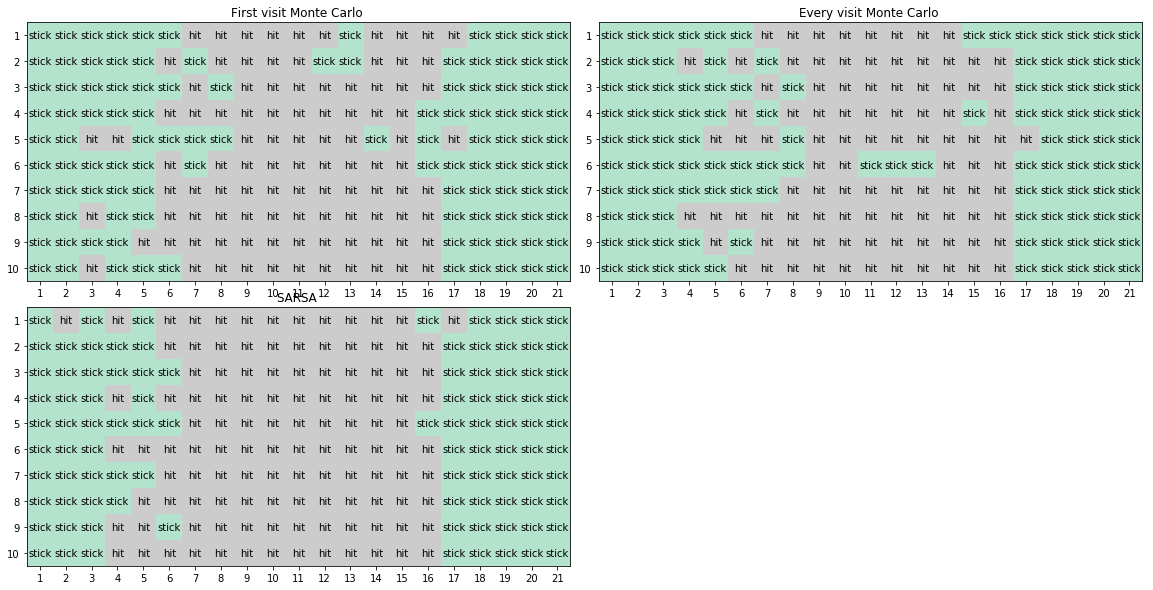

In [46]:
##################################################################################################
#                               Plotting optimal policy for each method                          #
##################################################################################################

def plotPolicy(plotablePi, ax):
    im = ax.imshow(np.array(plotablePi), cmap=cm.Pastel2_r)

    # We want to show all ticks...
    ax.set_xticks(range(21))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(1, 22))
    ax.set_yticklabels(range(1, 11))

    for i in range(10):
        for j in range(21):
            text = ax.text(j,i, "hit" if plotablePi[i][j] == 0 else "stick",
                           ha="center", va="center", color="black")

print("# Optimal policies obtaind from the Q* function of each method")
plotMutiplePolicies([qMCFV[-1], qMCEV[-1], qSARSA[-1]], ['First visit Monte Carlo', 'Every visit Monte Carlo', 'SARSA'], 
                    rows=2, cols=2, width=20.5, height=10)

The plots above shows how close are the policies generated by each method, which leads us to conclude that the policy obtained by all methods is very similar.

## Conclusion

The action-value functions obtained in the methods above are somewhat different from the expected if comparing to the shape of the value functions obtained in the [prediction exercise](https://github.com/renato-scaroni/ReinforcementLearning-knowledgeBase/blob/master/Implementations/easy21/Easy21-prediction-scaroni.ipynb).
But the shape obtained is consistent to the optimal policy generated, as it tends to stick the closer the player is to 1 or to 21, with a little tendency to hit more when closer to the lower bound then to the upper bound. This behaviour is a little obvious as hitting close to the bounds leads to greater chance of "going bust".

Also it is worth pointing that bootstrapping usually leads to more well behavioured action-values as these method generates less variance then operating over the total return.